## 0. Install & Import Dependencies

In [1]:
%pip install tqdm
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [50]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    average_precision_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from sklearn import preprocessing

from collections import Counter

In [3]:
# Root Directory.
BASE_DIR = "YOUR_PATH_HERE"
os.makedirs(BASE_DIR, exist_ok=True)

# Dataset directory.
CALTECH101_DIR = os.path.join(BASE_DIR, "101_ObjectCategories")

LOGS_DIR = os.path.join(BASE_DIR, "logs")

## Download Data

In [ ]:
# The file is downloaded manually because there are problems with GDrive permissions.
!tar -xvf 'caltech101/101_ObjectCategories.tar.gz'

## Load Dataset

In [4]:
# Get cpu, mps or gpu device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [9]:
# Transform the images to the format that the model expects.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the Caltech101 dataset.
caltech101_data = datasets.Caltech101(root=BASE_DIR, transform=transform)
num_classes = len(caltech101_data.categories)

print(f"Number of classes: {num_classes}")
print(f"Number of images: {len(caltech101_data)}")

Number of classes: 101
Number of images: 8677


In [10]:
# Split data into train and test.
train_ratio = 0.7
batch_size = 256

train_size = int(train_ratio * len(caltech101_data))
test_size = len(caltech101_data) - train_size

torch.manual_seed(25)
train_dataset, test_dataset = random_split(caltech101_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 6073
Test size: 2604


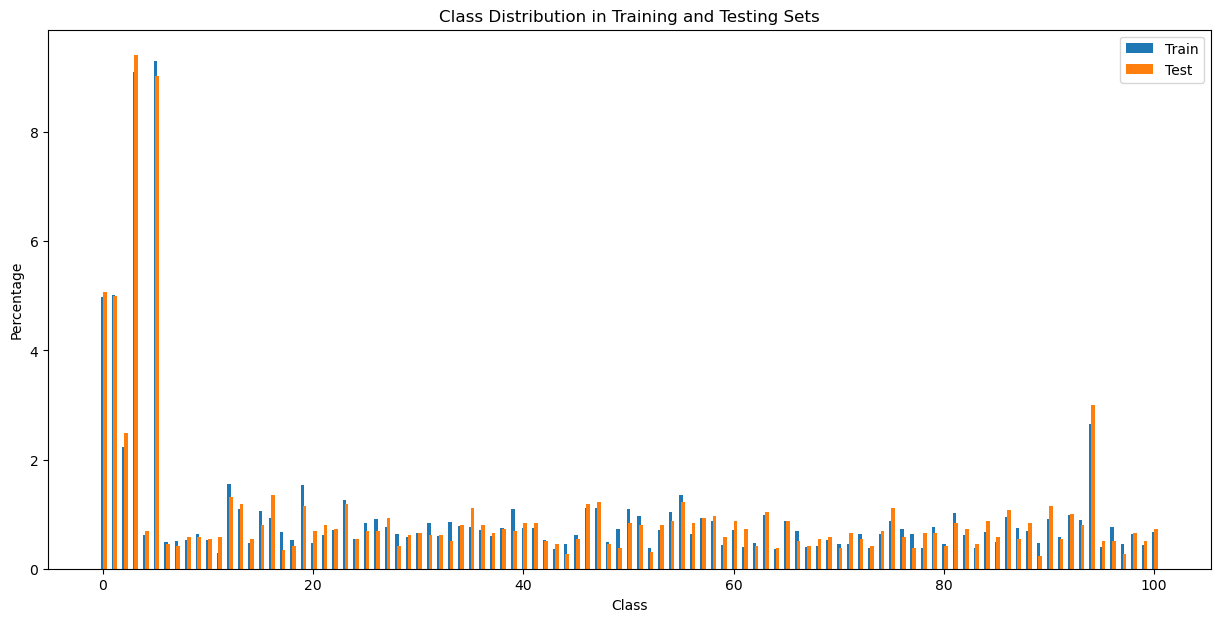

In [7]:
# Compute class distributions for both train and test sets

def plot_class_distribution(train_dataset, test_dataset):
    # Initialize dictionary to hold class distribution in train set
    train_class_distribution = {key: 0 for key in range(len(caltech101_data.categories))}

    for idx in train_dataset.indices:
        label = caltech101_data[idx][1]  # Get the label at that index
        train_class_distribution[label] += 1

    # Similarly for test set
    test_class_distribution = {key: 0 for key in range(len(caltech101_data.categories))}

    for idx in test_dataset.indices:
        label = caltech101_data[idx][1]  # Get the label at that index
        test_class_distribution[label] += 1

    train_classes = list(train_class_distribution.keys())
    train_counts = list(train_class_distribution.values())

    test_classes = list(test_class_distribution.keys())
    test_counts = list(test_class_distribution.values())


    # Compute the percentage of each class
    train_percentages = [x/sum(train_counts) * 100 for x in train_counts]
    test_percentages = [x/sum(test_counts) * 100 for x in test_counts]

    # Plot the distributions
    plt.figure(figsize=(15,7))

    # Create bar plots
    width = 0.35
    plt.bar(train_classes, train_percentages, width, label='Train')
    plt.bar(test_classes, test_percentages, width, label='Test', align='edge')

    plt.title('Class Distribution in Training and Testing Sets')
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.legend()

    plt.show()

plot_class_distribution(train_dataset, test_dataset)

## 1. Define Networks

### Plain 3-layer CNN

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) # -> 6x222x222
        self.pool = nn.MaxPool2d(2, 2) # -> 6x111x111
        self.conv2 = nn.Conv2d(6, 9, 3) # -> 9x108x108
        # pool -> 9x54x54
        self.conv3 = nn.Conv2d(9, 12, 3) # -> 12x52x52
        # pool -> 12x26x26

        self.fc1 = nn.Linear(12 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, num_classes)

    # x represents our data
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [12]:
plain_model = CNN().to(device)
plain_model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8112, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=101, bias=True)
)

### Frozen pre-trained ResNet as feature extractor

In [13]:
# Load the model.
frozen_resnet18 = models.resnet18(pretrained=True)

# Freeze Convolution layers.
for param in frozen_resnet18.parameters():
    param.requires_grad = False

num_ftrs = frozen_resnet18.fc.in_features
resnet18_fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.Linear(128, num_classes),
)
frozen_resnet18.fc = resnet18_fc
frozen_resnet18 = frozen_resnet18.to(device)

/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Fine-tuned pre-trained ResNet
Tested both partially and fully unfrozen layers

In [15]:
# Load the model.
resnet18 = models.resnet18(pretrained=True)

# Define the new fully connected layer for a fully unfrozen model.
num_ftrs = resnet18.fc.in_features
resnet18_fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.Linear(128, num_classes),
)
resnet18.fc = resnet18_fc
resnet18 = resnet18.to(device)

In [17]:
# Load the model.
partially_unfrozen_resnet18 = models.resnet18(pretrained=True)

# Freeze Convolution layers.
for param in partially_unfrozen_resnet18.parameters():
    param.requires_grad = False

# Unfreeze the last three layers of the model.
params = list(partially_unfrozen_resnet18.layer4.parameters())
for param in params[-1:-4:-1]:
    param.requires_grad = True

# Unfreeze the avgpool layer.
for param in partially_unfrozen_resnet18.avgpool.parameters():
    param.requires_grad = True

# Define the new fully connected layer for a partially unfrozen model.
num_ftrs = partially_unfrozen_resnet18.fc.in_features
resnet18_fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.Linear(128, num_classes),
)
partially_unfrozen_resnet18.fc = resnet18_fc
partially_unfrozen_resnet18 = partially_unfrozen_resnet18.to(device)

print("Unfrozen layers:")
for name, param in partially_unfrozen_resnet18.named_parameters():
    if param.requires_grad:
        print(name)

Unfrozen layers:
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/batiukmaks/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train models

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        EarlyStopping can be used to stop the training if no improvement after
        :param patience: How long to wait after last time validation loss improved.
        :param delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, loss):
        score = -loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [20]:
def train(dataloader, model, loss_fn, optimizer, accumulation_steps=3):
    size = len(dataloader.dataset)

    model.train()
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.benchmark = True

    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)
    optimizer.zero_grad()

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction error
        pred = model(X)
        pred = pred.squeeze(1)
        loss = loss_fn(pred, y)

        # Gradient Accumulation
        loss.backward()

        if (idx+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        preds = torch.cat((preds, pred))
        targets = torch.cat((targets, y))

    # Perform a final step if some accumulated gradients remain
    if idx % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return preds, targets

In [21]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            # Compute prediction error.
            pred = model(X)

            preds = torch.cat((preds, pred))
            targets = torch.cat((targets, y))

    preds = preds.squeeze()

    return preds, targets

In [22]:
# Initialize TensorBoard writer for adding new data on the charts.
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=LOGS_DIR)

In [24]:
def run_train_test_process(
        model,
        loss_fn,
        optimizer,
        train_dataloader,
        test_dataloader,
        early_stopping,
        epochs=20,
        model_name="model"
):
    for epoch in tqdm(range(1, epochs + 1), "Epochs"):
        # Train and validate the model.
        preds, targets = train(train_dataloader, model, loss_fn, optimizer)
        test_preds, test_targets = test(test_dataloader, model)

        # Compute accuracy.
        train_accuracy = accuracy_score(targets.cpu(), torch.argmax(preds, dim=1).cpu())
        test_accuracy = accuracy_score(test_targets.cpu(), torch.argmax(test_preds, dim=1).cpu())

        # Compute error rate.
        top1_train_error_rate = 1 - train_accuracy
        top1_test_error_rate = 1 - test_accuracy
        
        # Add data to TensorBoard graphs.
        writer.add_scalars(f'{model_name}/Loss',{
            'train': loss_fn(preds, targets).item(),
            'test': loss_fn(test_preds, test_targets).item()
        }, epoch)

        writer.add_scalars(f'{model_name}/Top1 Error rate',{
            'train': top1_train_error_rate,
            'test': top1_test_error_rate
        }, epoch)

        writer.add_scalars(f'{model_name}/Accuracy',{
            'train': train_accuracy,
            'test': test_accuracy
        }, epoch)

        # Check if the model should be stopped.
        early_stopping(loss_fn(preds, targets).item())
        if early_stopping.early_stop:
            print(f"Early stopping on epoch [{epoch}].")
            break

In [ ]:
my_models = [
    (plain_model, "plain_model"),
    (frozen_resnet18, "frozen_resnet18"),
    (resnet18, "resnet18"),
    (partially_unfrozen_resnet18, "partially_unfrozen_resnet18")
]

In [ ]:
for model, model_name in my_models:
    print(f"Training {model_name} model.")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=5, delta=0.001)

    run_train_test_process(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        early_stopping=early_stopping,
        epochs=10,
        model_name=model_name
    )

In [ ]:
# Save models
os.makedirs("models", exist_ok=True)
for model, model_name in my_models:
    torch.save(model, f"models/{model_name}.pth")

## 2. Result Reports (Analysis)

In [25]:
# Set the list of model names
model_names = ["plain_model", "frozen_resnet18", "resnet18", "partially_unfrozen_resnet18"]

# Initialize list to hold fully-loaded models
loaded_models = []

# Load the full model for each name
for model_name in model_names:
    model = torch.load(f"models/{model_name}.pth", map_location=device)
    model.to(device)
    loaded_models.append((model, model_name))

#### Classification Reports

In [29]:
# Define the function to get the classification report in the form of a DataFrame.
def get_classification_report(y_true, y_pred, model_name, data_type):
    report = classification_report(
        y_true, 
        y_pred, 
        output_dict=True, 
        target_names=caltech101_data.categories
    )

    # Construct the DataFrame.
    report_df = pd.DataFrame(report).transpose()
    report_df.insert(loc=0, column='Model', value=model_name)  # Add 'Model' column
    report_df.insert(loc=1, column='Data', value=data_type)    # Add 'Data' column

    return report_df

reports = []

# Compute classification report for training data.
for model, model_name in loaded_models:
    raw_scores, y_true = test(train_loader, model)
    _, y_pred = torch.max(raw_scores, 1)
    y_pred = y_pred.squeeze().detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    report_df = get_classification_report(y_true, y_pred, model_name, 'Train')
    reports.append(report_df)

# Compute classification report for validation data.
for model, model_name in loaded_models:
    raw_scores, y_true = test(test_loader, model)
    _, y_pred = torch.max(raw_scores, 1)
    y_pred = y_pred.squeeze().detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    report_df = get_classification_report(y_true, y_pred, model_name, 'Val')
    reports.append(report_df)

# Concatenate all the DataFrames together.
all_reports_df = pd.concat(reports)

# Save the DataFrame to a CSV file.
os.makedirs('reports', exist_ok=True)
all_reports_df.to_csv('reports/classification_reports.csv')

# Remove display limit for rows and columns.
pd.set_option('display.max_rows', None)
all_reports_df

,Model,Data,precision,recall,f1-score,support
Faces,plain_model,Train,0.719072,0.920792,0.807525,303.000000
Faces_easy,plain_model,Train,0.976109,0.937705,0.956522,305.000000
Leopards,plain_model,Train,0.643243,0.881481,0.743750,135.000000
Motorbikes,plain_model,Train,0.808824,0.994575,0.892133,553.000000
accordion,plain_model,Train,0.958333,0.621622,0.754098,37.000000
airplanes,plain_model,Train,0.901042,0.918584,0.909728,565.000000
anchor,plain_model,Train,0.520000,0.433333,0.472727,30.000000
ant,plain_model,Train,0.217391,0.161290,0.185185,31.000000
barrel,plain_model,Train,0.125000,0.031250,0.050000,32.000000
bass,plain_model,Train,0.583333,0.358974,0.444444,39.000000


#### 101x101 Confusion Matrices

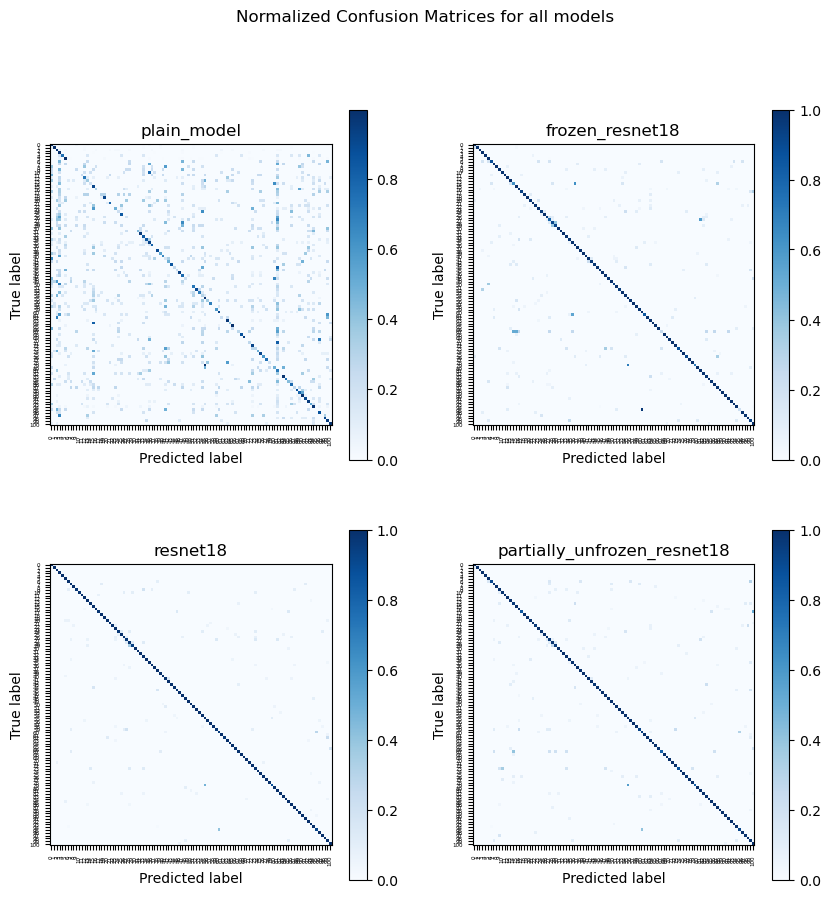

In [43]:
# Define a large enough figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

model_idx = 0
for row in range(2):
    for col in range(2):
        if model_idx < len(loaded_models):
            model, model_name = loaded_models[model_idx]
            model_preds, model_targets = test(test_loader, model)
            model_preds = np.argmax(model_preds.cpu().numpy(), axis=1)
            model_targets = model_targets.cpu().numpy()

            # Generate confusion matrix
            cm = confusion_matrix(y_true=model_targets, y_pred=model_preds)

            # Normalize confusion matrix
            cm = preprocessing.normalize(cm)

            ax = axes[row, col]

            # Create a confusion matrix display object without labels
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(include_values=False, cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
            
            ax.tick_params(axis='x', labelsize=4) # specify label size of x-axis
            ax.tick_params(axis='y', labelsize=4) # specify label size of y-axis
            ax.set_title(f'{model_name}')

            model_idx += 1

plt.suptitle('Normalized Confusion Matrices for all models')
plt.show()

#### Learning curves & The top-1 error rate

In [45]:
%load_ext tensorboard
%tensorboard --logdir "YOUR_PATH_HERE/logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 40390), started 0:00:12 ago. (Use '!kill 40390' to kill it.)

#### ROC Curve

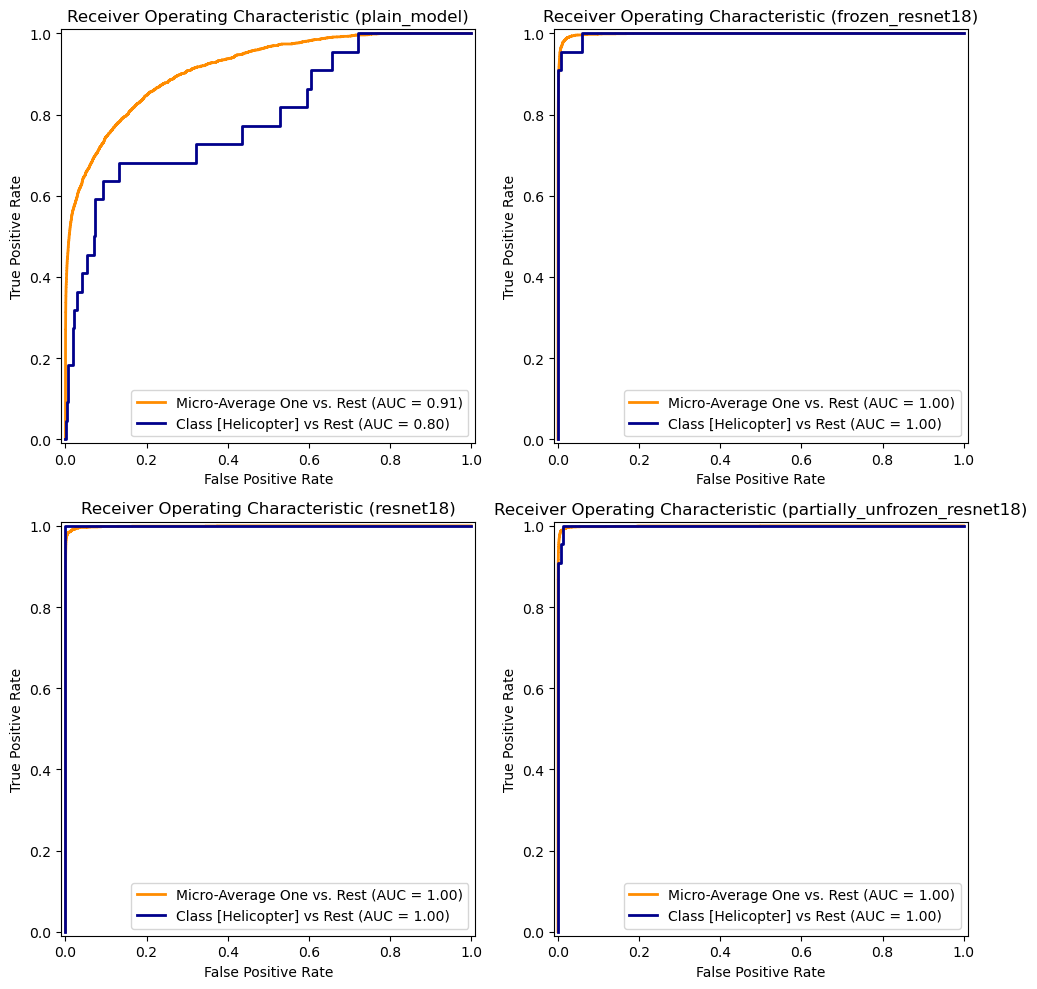

In [49]:
def plot_roc_curves(class_id):
    # Get y from the test_dataset
    y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
    y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

    # Binarize the labels
    label_binarizer = preprocessing.LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    # Initialize the figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    class_name = caltech101_data.categories[class_id]

    for ax, (model, model_name) in zip(axes.flatten(), loaded_models):
        # Get the predictions and targets
        preds, targets = test(test_loader, model)
        y_score = F.softmax(preds, dim=1).detach().cpu().numpy()

        RocCurveDisplay.from_predictions(
            y_onehot_test.ravel(),
            y_score.ravel(),
            name=f"Micro-Average One vs. Rest",
            color="darkorange",
            ax=ax,
            lw=2
        )

        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"Class [{class_name.title()}] vs Rest",
            color="darkblue",
            ax=ax,
            lw=2
        )

        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("Receiver Operating Characteristic " + f"({model_name})")
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

plot_roc_curves(class_id=50)

#### AUC-PRC

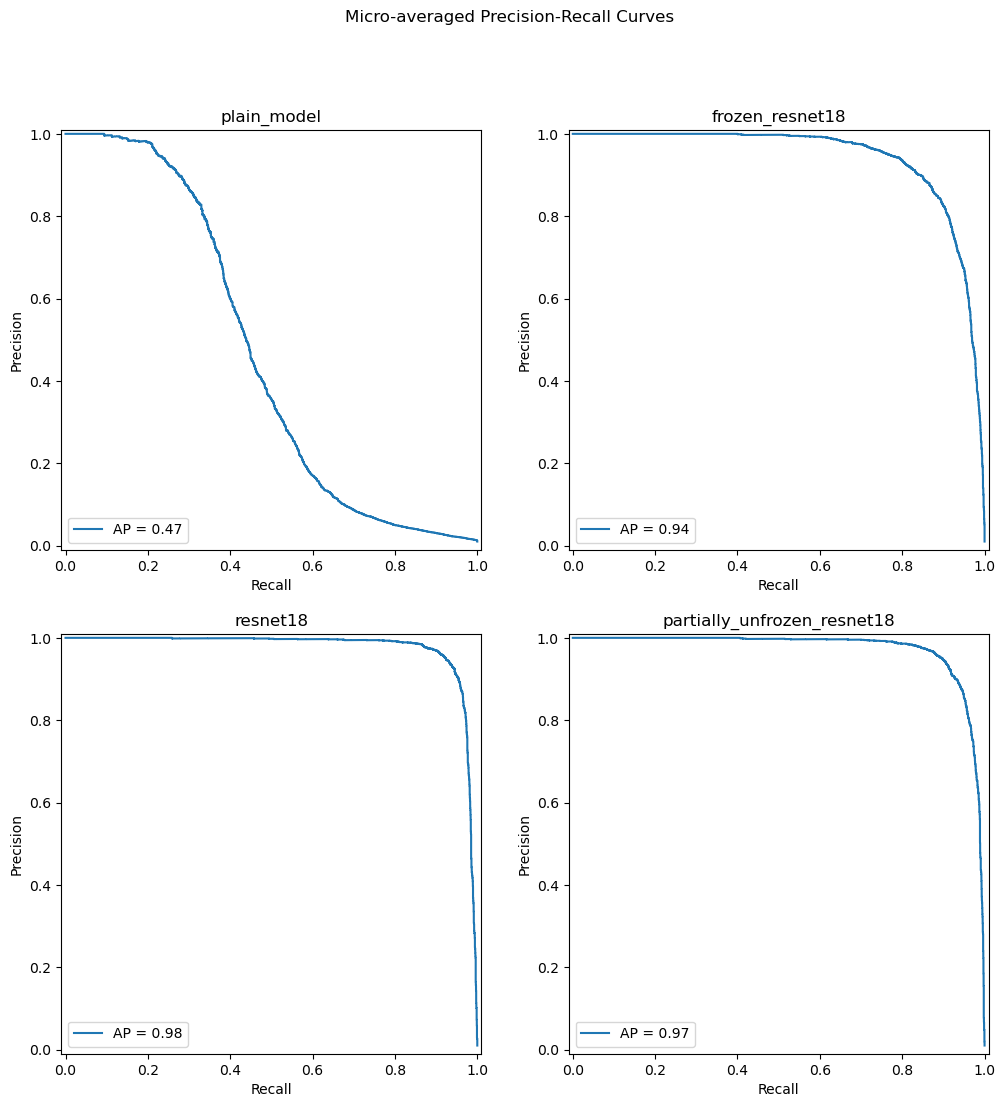

In [56]:
def plot_precision_recall_curves():
    y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
    y_onehot_test = preprocessing.label_binarize(y_test, classes=range(num_classes))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    axes = axes.flatten()
    for idx, (model, model_name) in enumerate(loaded_models):
        preds, targets = test(test_loader, model)
        y_score = F.softmax(preds, dim=1).detach().cpu().numpy()
        
        # Compute Precision-Recall
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

        # Compute micro-average ROC curve and ROC area
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_onehot_test.ravel(), y_score.ravel()
        )
        average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

        # Plot Precision-Recall curve 
        display = PrecisionRecallDisplay(
            recall=recall["micro"], 
            precision=precision["micro"], 
            average_precision=average_precision["micro"]
        )
        display.plot(ax = axes[idx])
        _ = axes[idx].set_title(f"{model_name}") 

    # plt.tight_layout()
    plt.suptitle("Micro-averaged Precision-Recall Curves")
    plt.show()

plot_precision_recall_curves()

#### The top-1 error rate in %

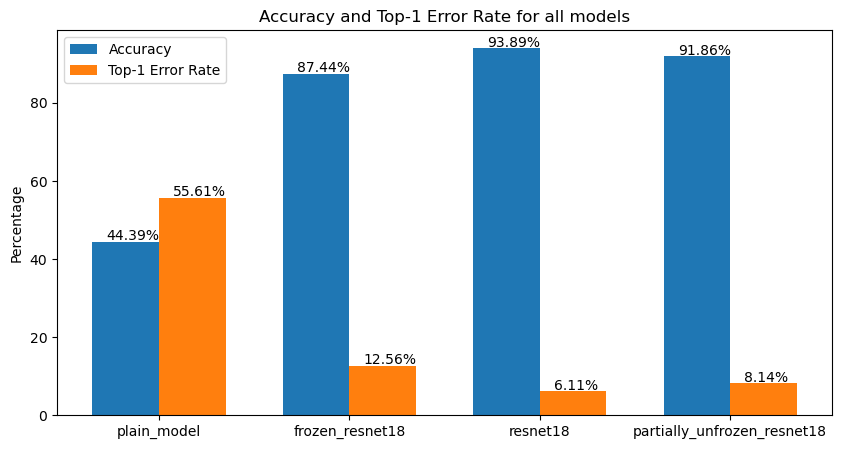

In [62]:
def plot_accuracy_and_top1_error_rate():
    top_1_error_rates = []
    accuracies = []
    for model, model_name in loaded_models:
        # Calculate accuracy for resnet18_best model
        preds, targets = test(test_loader, model)
        accuracy = accuracy_score(targets.cpu(), torch.argmax(preds, dim=1).cpu())
        accuracy_percentage = accuracy * 100

        # Calculate top-1 error rate for resnet18_best model
        top1_error_rate = 1 - accuracy
        top1_error_rate_percentage = top1_error_rate * 100

        accuracies.append(accuracy_percentage)
        top_1_error_rates.append(top1_error_rate_percentage)

    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a bar plot
    x = np.arange(len(loaded_models))
    width = 0.35
    ax.bar(x, accuracies, width, label='Accuracy')
    ax.bar(x + width, top_1_error_rates, width, label='Top-1 Error Rate')
    # Add numbers on the bars
    for i, v in enumerate(accuracies):
        ax.text(i - 0.1, v + 0.5, f"{v:.2f}%", color='black')
    for i, v in enumerate(top_1_error_rates):
        ax.text(i + 0.25, v + 0.5, f"{v:.2f}%", color='black')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('Accuracy and Top-1 Error Rate for all models')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels([model_name for _, model_name in loaded_models])
    ax.legend()

    plt.show()

plot_accuracy_and_top1_error_rate()

## 3. Visualize filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



### plain_model


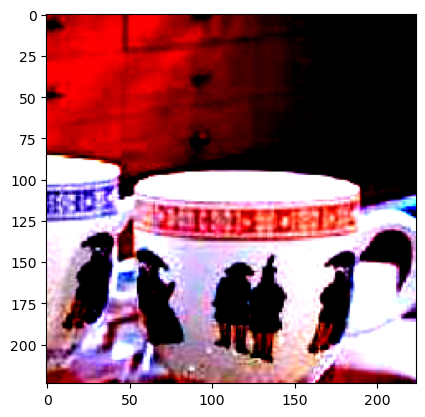

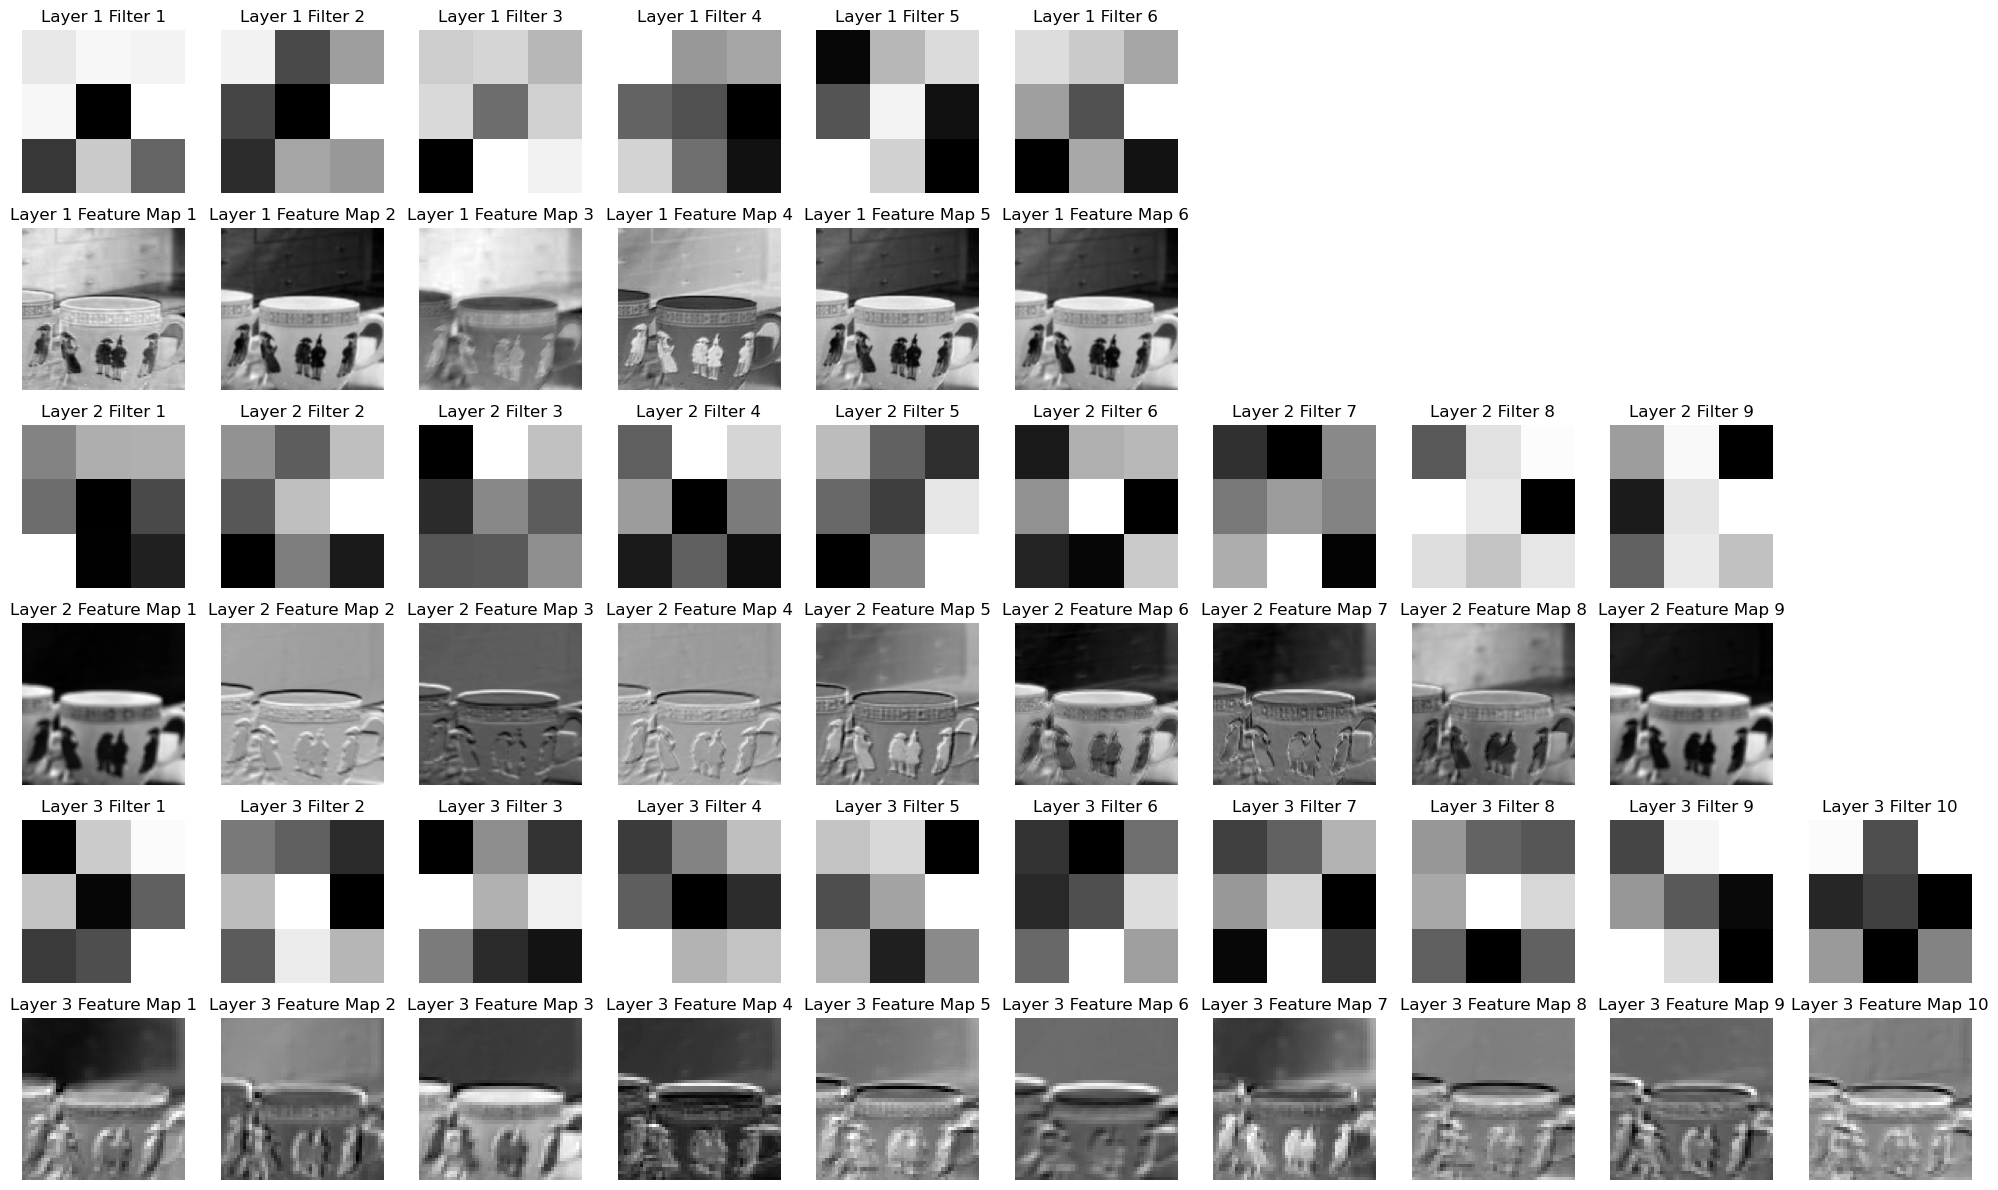


### frozen_resnet18


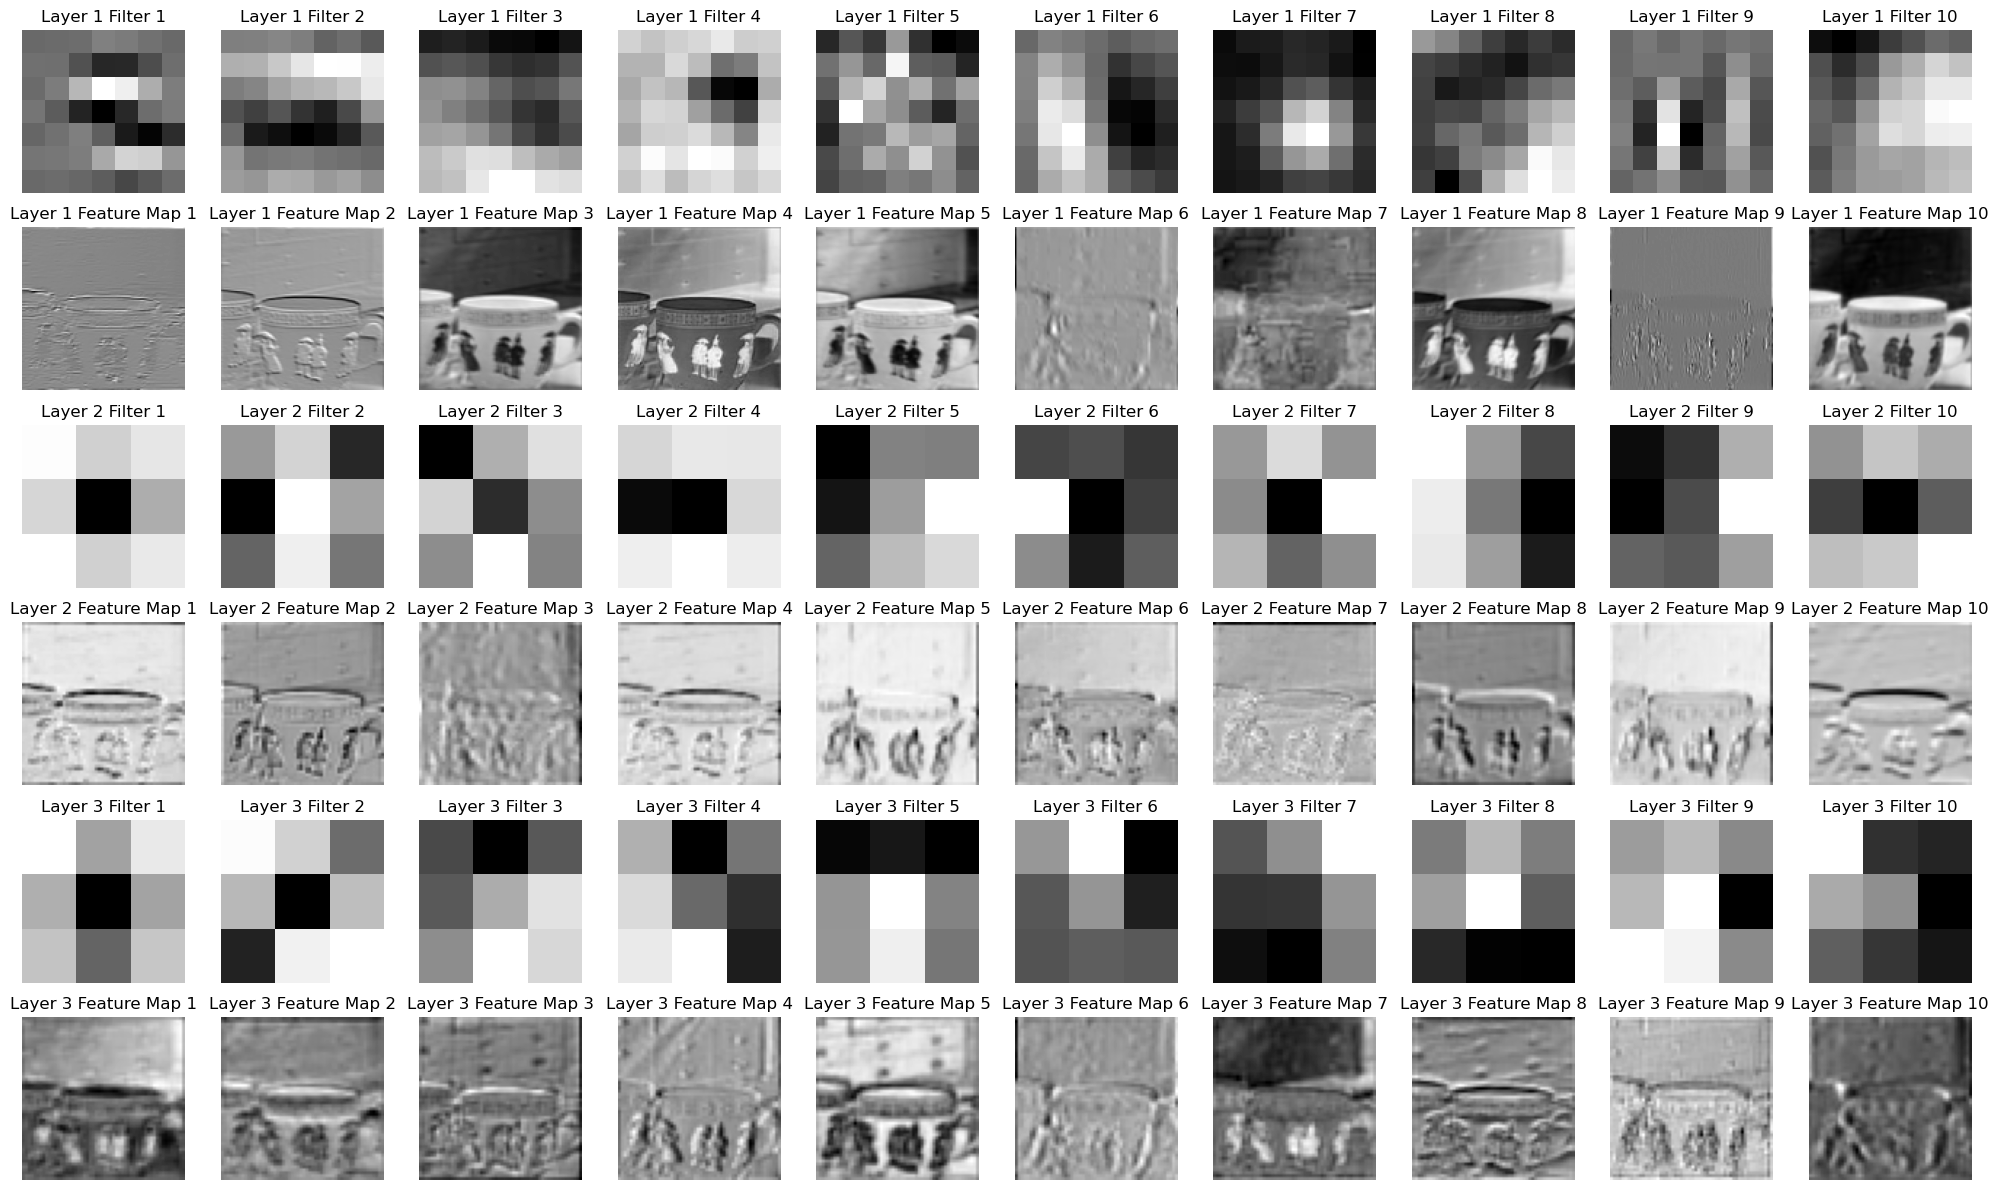


### resnet18


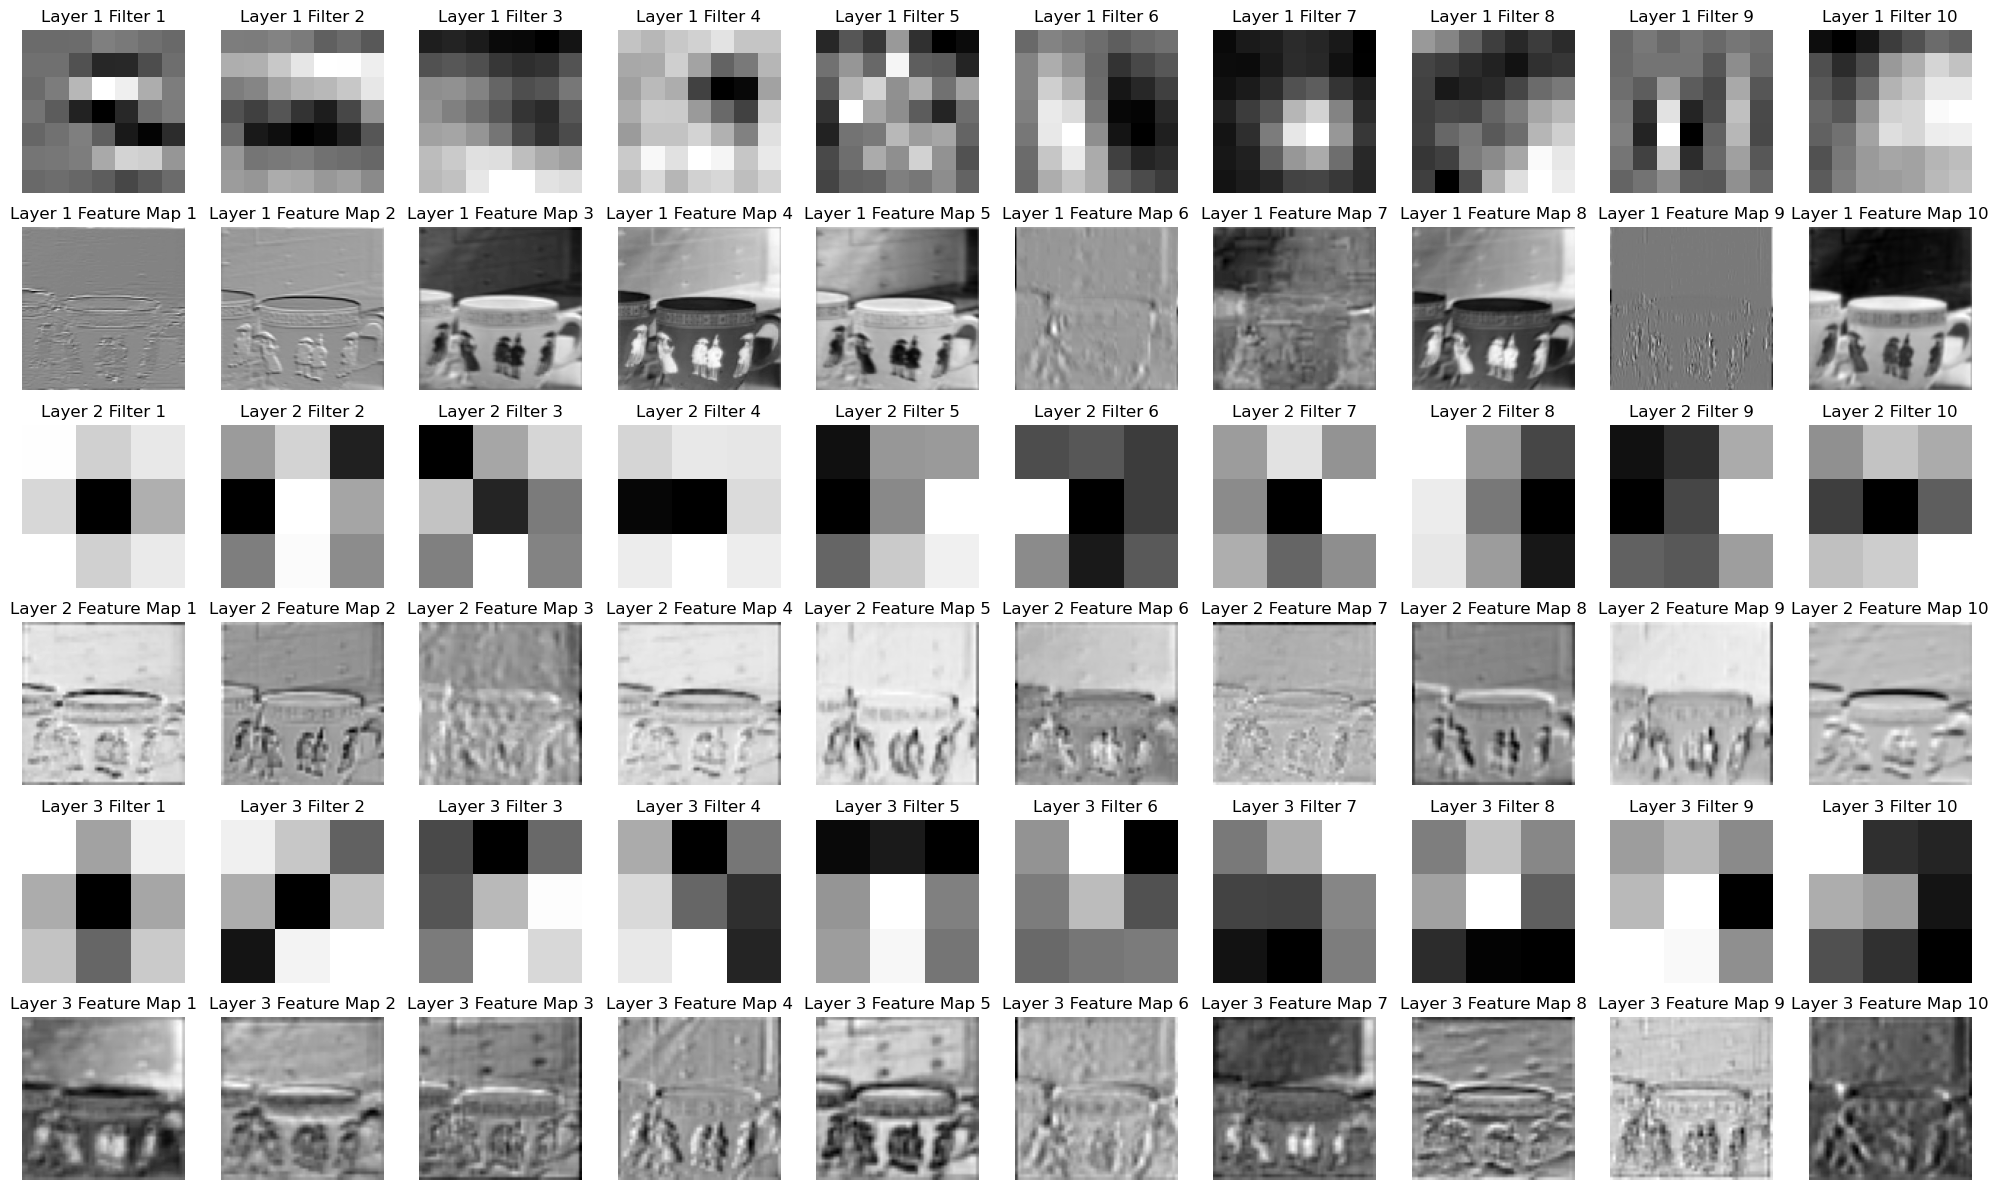


### partially_unfrozen_resnet18


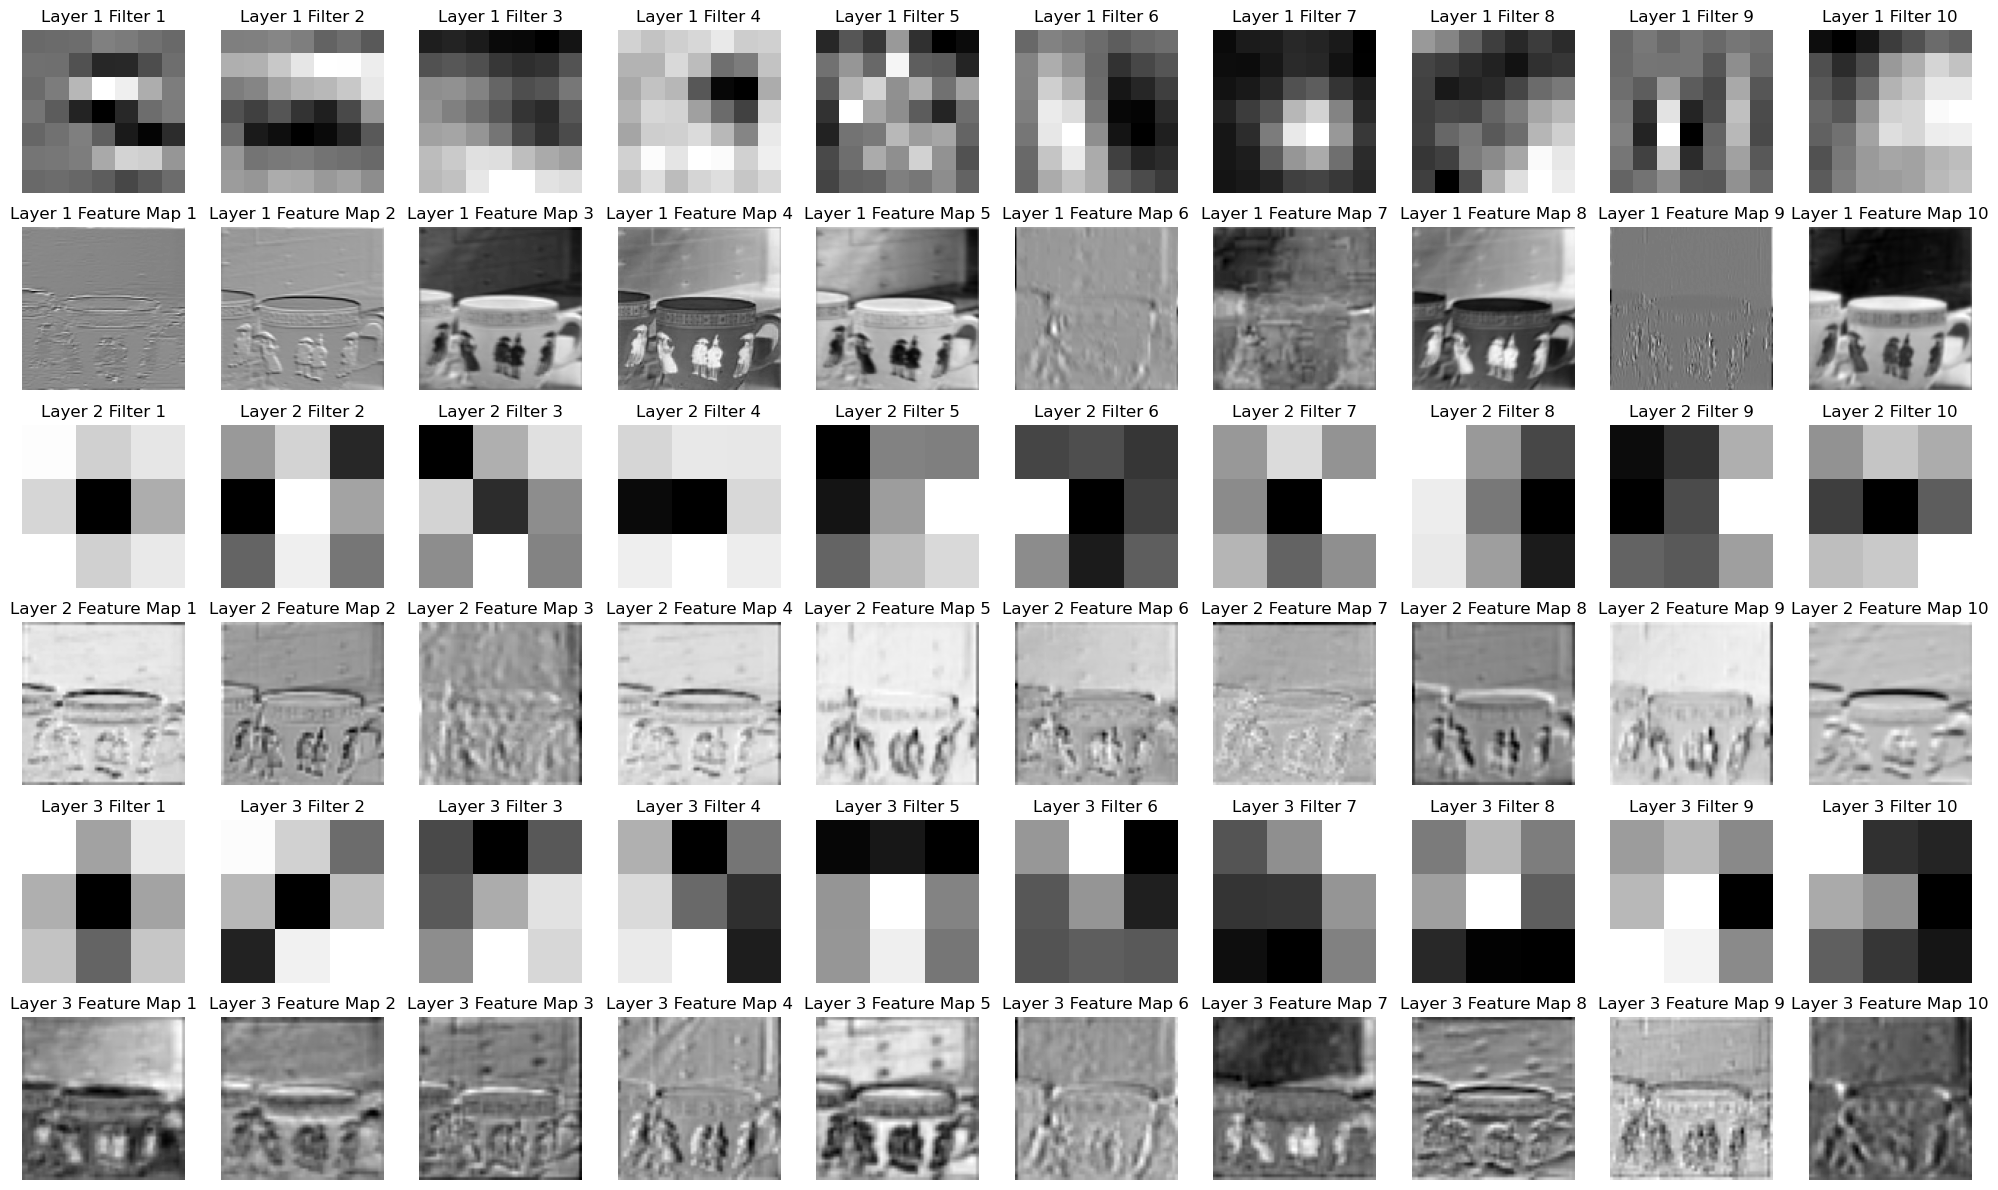

In [87]:
def visualize_filters_and_feature_maps(model, image, num_layers, plot_name, max_num_filters=10):
    # Get the convolutional layers
    conv_layers = [
        module for module in model.modules() 
        if isinstance(module, nn.Conv2d)
    ][:num_layers]

    # Register a hook to get the output of the convolutional layers
    layer_outputs = []
    def hook(module, input, output):
        layer_outputs.append(output)

    for layer in conv_layers:
        layer.register_forward_hook(hook)
    
    # Run the model
    image = image.unsqueeze(0).to(device)
    _ = model(image)
    
    fig, axs = plt.subplots(num_layers*2, max_num_filters, figsize=(max_num_filters*2, num_layers*4))
    for i, (layer, feature_map) in enumerate(zip(conv_layers, layer_outputs)):
        # Get the filters and feature maps
        filters = layer.weight.data.cpu().clone().numpy()
        num_filters = min(filters.shape[0], max_num_filters)
        feature_map = feature_map[0, :, :, :].cpu().data.numpy()

        for j in range(max_num_filters):
            # If we have less filters than max_num_filters, remove additional subplots
            if j >= num_filters:
                fig.delaxes(axs[i*2, j])
                fig.delaxes(axs[i*2+1, j])
                continue
            
            axs[i*2, j].imshow(filters[j, 0, :, :], cmap="gray")  # show filter
            axs[i*2, j].set_title(f"Layer {i+1} Filter {j+1}")
            axs[i*2, j].axis("off")

            axs[i*2+1, j].imshow(feature_map[j, :, :], cmap="gray")  # show feature map
            axs[i*2+1, j].set_title(f"Layer {i+1} Feature Map {j+1}")
            axs[i*2+1, j].axis("off")

    plt.tight_layout()
    plt.show()

image = test_dataset[5][0].to(device)
# Plot input image
plt.imshow(image.permute(1, 2, 0).cpu().numpy())


for model, model_name in loaded_models:
    print(f"\n### {model_name}")
    visualize_filters_and_feature_maps(model, image, num_layers=3, plot_name=model_name)

## 4. Explain the results

**1. What kind of features did filters extract?**
- As I observe, first layers of filters tried to extract contours and/or whole filled areas (in the visualization above: drawing on the cup). 
- On the second layer, I guess contours were extracted again, but now for the bigger areas. 
- Also, feature maps become more "blurred" on each layer, I guess it is because the model tries to extract minor details.

**2. Do you have "blind" filters that didn't learn anything? Why? How could you fix that?**
- Yes, some of the feature maps are just filled with one color (e.g. gray), I cannot see anything like an object on the input image. 
- I guess it happens because of the randomness of the initial filters and these filters haven't gotten enough iterations to learn or they have been stuck in some kind of "local minimum". 
- Maybe some regularization techniques could solve these issues. 

**3. Does your model consider the background of the inputs?**
- Most of the images in this dataset have the object clearly presented, clearly enough for model to extract its contours. 
- After manually checking feature maps on different input images, I would conclude that my model is not affected by the background as long as it can be easily distinguished from the object we want to classify.


**4. Does your model consider the color of the inputs?**
- I tried to pass grayscale images as input to see the affect. In most cases, filters on the first layer extracted contours not as precise as they did on colorful image. 
- So, I guess my model would perform better on colorful images because it was trained on such images.


## 5. Trained Model that achieves top-1 error rate < 15% and average accuracy ≥ 91%

In [90]:
resnet18_best = loaded_models[2][0]

# Calculate accuracy for resnet18_best model
preds, targets = test(test_loader, resnet18_best)
accuracy = accuracy_score(targets.cpu(), torch.argmax(preds, dim=1).cpu())
accuracy_percentage = accuracy * 100

# Calculate top-1 error rate for resnet18_best model
top1_error_rate = 1 - accuracy
top1_error_rate_percentage = top1_error_rate * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Top-1 Error Rate: {top1_error_rate_percentage:.2f}%")

Accuracy: 93.89%
Top-1 Error Rate: 6.11%
